In [1]:
# our commonly used functions
from global_bug_bot_functions import  *


# libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model

# libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2


# utility libraries
import os
import time
import itertools
import random
import numpy as np

# Force TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

# Set random seeds for reproducibility
seed_value = 2025
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# data set constants
TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR, shuffle_flag=False)
EVAL_VAL_GENERATOR = load_data(VALID_DIR, shuffle_flag=False)

# best hps found from tuning
# from ep20_pat3_del0.001_ex1_maxtr20_from_tuning_script_final_tuned_models_results_DenseNet201.csv
# ---> tuned with max epoch = 20, patience = 3, minimum delta = 0.001, max trials = 20
best_lr = 0.01
best_dropout = 0.4
best_batch_size	= 64
best_epochs	= 15

with tf.device('/GPU:0'):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # freeze the base model layers
    base_model.trainable = False
    
    # global pooling and dropout layers included similar to jute pest architecture
    x = BatchNormalization()(base_model.output) # JUST ADDED
    x = Dropout(best_dropout)(x) # JUST ADDED
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dropout(best_dropout)(x)
    x = BatchNormalization()(x) # JUST ADDED
    
    # final softmax probabilistic classification layer - JUST ADDED L2
    output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax', kernel_regularizer=l2(0.05))(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    optimizer = Adam(learning_rate=best_lr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # JUST ADDED: get init accuracy before training
    initial_loss_val, initial_accuracy_val = model.evaluate(VAL_GENERATOR)
    initial_loss_train, initial_accuracy_train = model.evaluate(TRAIN_GENERATOR)
    
    print("Metrics Before Training:")
    print(f" - Training   -> Loss: {initial_loss_train:.4f}, Accuracy: {initial_accuracy_train:.4f}")
    print(f" - Validation -> Loss: {initial_loss_val:.4f}, Accuracy: {initial_accuracy_val:.4f}")
    
    history = model.fit(TRAIN_GENERATOR,validation_data=VAL_GENERATOR, epochs = best_epochs, batch_size = best_batch_size)
    
    # append intial values for plotting
    history.history['accuracy'].insert(0, initial_accuracy_train) #training
    history.history['loss'].insert(0, initial_loss_train)  # training
    
    history.history['val_accuracy'].insert(0, initial_accuracy_val)  # validation
    history.history['val_loss'].insert(0, initial_loss_val)  # validation



Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 6108 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
191/191 [==============================] - 19s 98ms/step - loss: 3.8398 - accuracy: 0.0994
Metrics Before Training:
 - Training   -> Loss: 3.8398, Accuracy: 0.0994
 - Validation -> Loss: 3.7901, Accuracy: 0.1045
Epoch 1/15
191/191 [==============================] - 30s 110ms/step - loss: 2.5614 - accuracy: 0.6536 - val_loss: 2.3019 - val_accuracy: 0.6636
Epoch 2/15
191/191 [==============================] - 24s 127ms/step - loss: 2.1801 - accuracy: 0.6870 - val_loss: 2.1826 - val_accuracy: 0.6477
Epoch 3/15
191/191 [==============================] - 23s 122ms/step - loss: 2.0505 - accuracy: 0.6970 - val_loss: 2.1495 - val_accuracy: 0.6523
Epoch 4/15
191/191 [==============================] - 24s 127ms/step - loss: 1.9894 - accuracy: 0.6953 - val

# Validation plots

14/14 [==============================] - 5s 99ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.800000,0.500000,0.615385,40.000000
american_house_spider,0.958333,0.575000,0.718750,40.000000
bedbug,0.633333,0.475000,0.542857,40.000000
brown_stink_bug,0.659574,0.775000,0.712644,40.000000
carpenter_ant,0.550000,0.825000,0.660000,40.000000
cellar_spider,0.782609,0.900000,0.837209,40.000000
flea,0.500000,0.475000,0.487179,40.000000
house_centipede,0.939394,0.775000,0.849315,40.000000
silverfish,0.852941,0.725000,0.783784,40.000000
subterranean_termite,0.412698,0.650000,0.504854,40.000000


<Figure size 800x600 with 0 Axes>

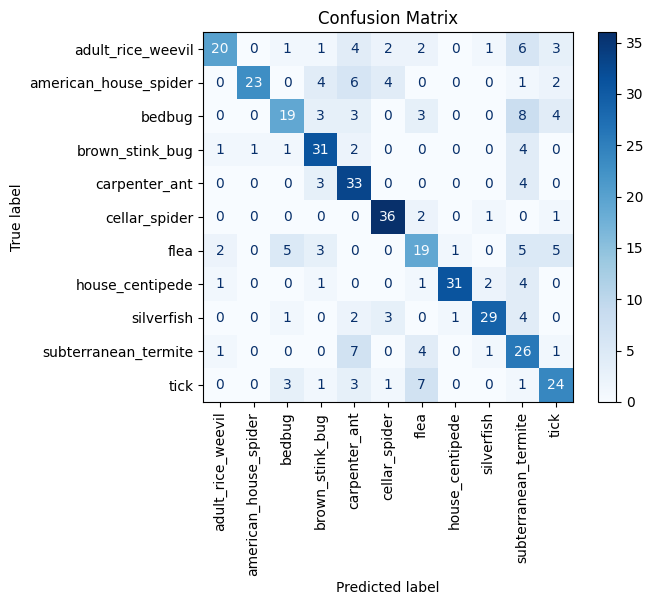

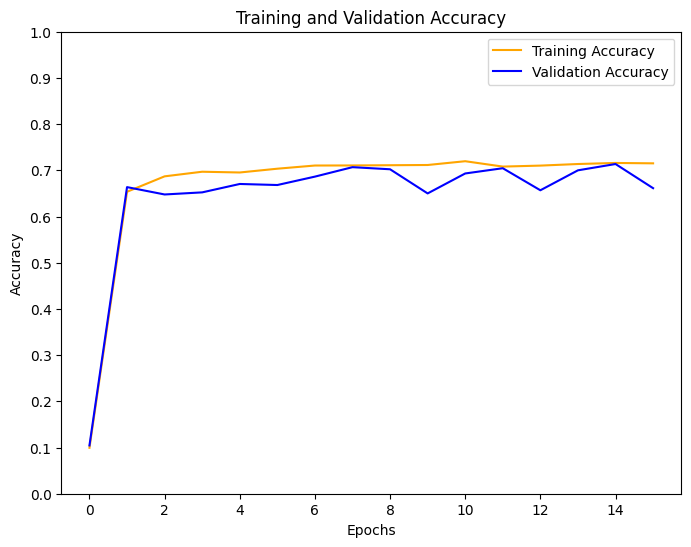

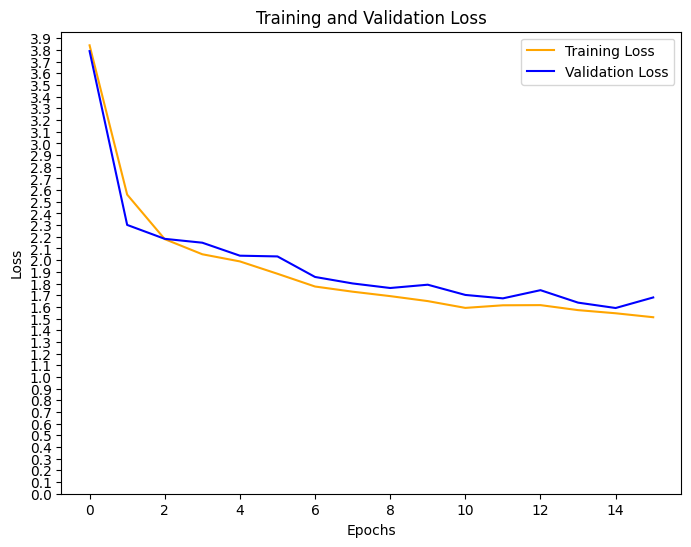

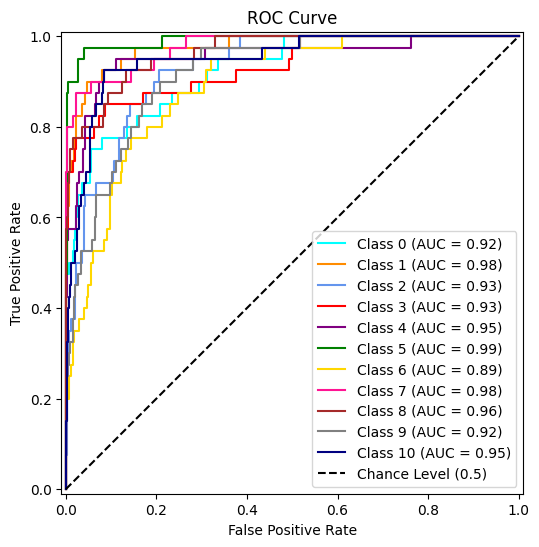

Macro-averaged One-vs-Rest ROC AUC score: 0.95
Accuracy: 0.661
Precision: 0.699
Recall: 0.661
F1 Score: 0.665


{'accuracy': 0.661,
 'precision': 0.699,
 'recall': 0.661,
 'f1_score': 0.665,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.800000  0.500000  0.615385   40.000000
 american_house_spider   0.958333  0.575000  0.718750   40.000000
 bedbug                  0.633333  0.475000  0.542857   40.000000
 brown_stink_bug         0.659574  0.775000  0.712644   40.000000
 carpenter_ant           0.550000  0.825000  0.660000   40.000000
 cellar_spider           0.782609  0.900000  0.837209   40.000000
 flea                    0.500000  0.475000  0.487179   40.000000
 house_centipede         0.939394  0.775000  0.849315   40.000000
 silverfish              0.852941  0.725000  0.783784   40.000000
 subterranean_termite    0.412698  0.650000  0.504854   40.000000
 tick                    0.600000  0.600000  0.600000   40.000000
 accuracy                0.661364  0.661364  0.661364    0.661364
 macro avg               0.698989  

In [2]:
%matplotlib inline
evaluation_metrics(model, EVAL_VAL_GENERATOR, history)


# Validation metrics: 'accuracy': 0.661,'precision': 0.699,'recall': 0.661,'f1_score': 0.665

# Test plots

7/7 [==============================] - 1s 101ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.916667,0.550000,0.687500,20.000000
american_house_spider,0.928571,0.650000,0.764706,20.000000
bedbug,0.777778,0.700000,0.736842,20.000000
brown_stink_bug,0.772727,0.850000,0.809524,20.000000
carpenter_ant,0.566667,0.850000,0.680000,20.000000
cellar_spider,0.772727,0.850000,0.809524,20.000000
flea,0.500000,0.650000,0.565217,20.000000
house_centipede,1.000000,0.750000,0.857143,20.000000
silverfish,0.923077,0.600000,0.727273,20.000000
subterranean_termite,0.411765,0.700000,0.518519,20.000000


<Figure size 800x600 with 0 Axes>

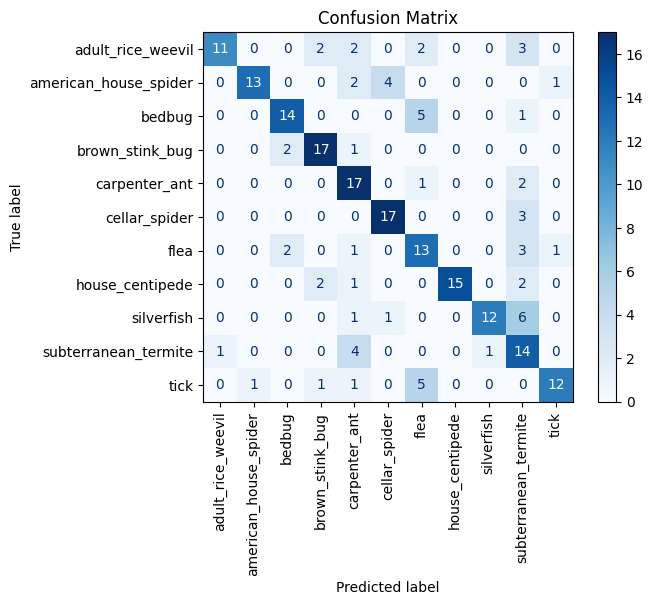

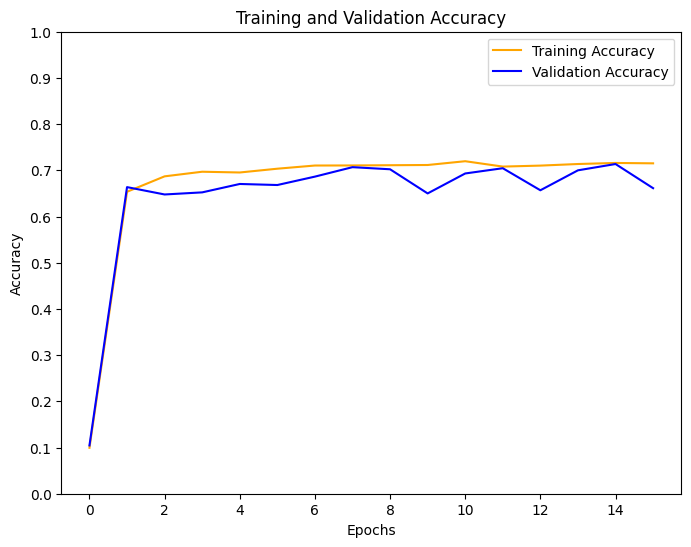

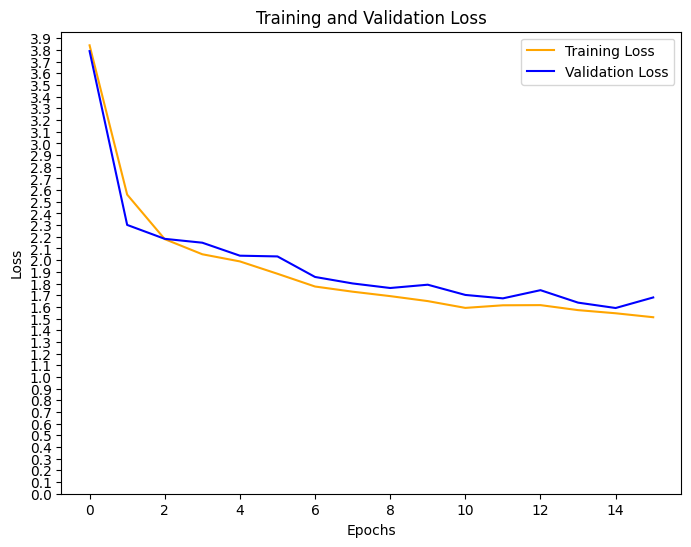

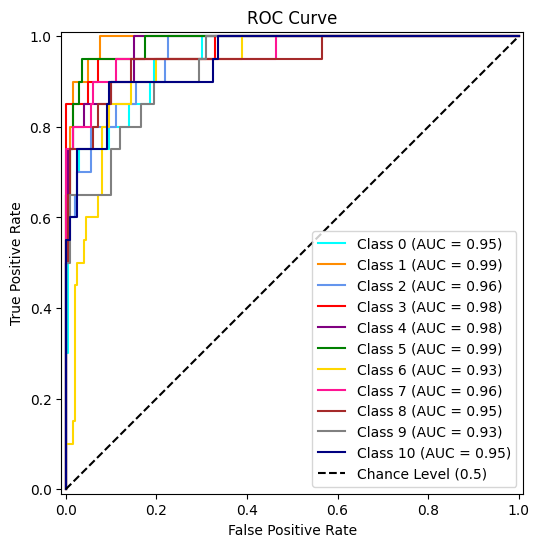

Macro-averaged One-vs-Rest ROC AUC score: 0.96
Accuracy: 0.705
Precision: 0.766
Recall: 0.705
F1 Score: 0.715


{'accuracy': 0.705,
 'precision': 0.766,
 'recall': 0.705,
 'f1_score': 0.715,
 'classification_report_df':                        precision    recall  f1-score     support
 adult_rice_weevil       0.916667  0.550000  0.687500   20.000000
 american_house_spider   0.928571  0.650000  0.764706   20.000000
 bedbug                  0.777778  0.700000  0.736842   20.000000
 brown_stink_bug         0.772727  0.850000  0.809524   20.000000
 carpenter_ant           0.566667  0.850000  0.680000   20.000000
 cellar_spider           0.772727  0.850000  0.809524   20.000000
 flea                    0.500000  0.650000  0.565217   20.000000
 house_centipede         1.000000  0.750000  0.857143   20.000000
 silverfish              0.923077  0.600000  0.727273   20.000000
 subterranean_termite    0.411765  0.700000  0.518519   20.000000
 tick                    0.857143  0.600000  0.705882   20.000000
 accuracy                0.704545  0.704545  0.704545    0.704545
 macro avg               0.766102  

In [3]:
%matplotlib inline
evaluation_metrics(model, TEST_GENERATOR, history)


# Test metrics: 'accuracy': 0.705, 'precision': 0.766,'recall': 0.705, 'f1_score': 0.715